In [ ]:
#@title Run this cell to load everything :)
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Self%20Driving%20Cars/gathered.pkl' > /dev/null 2>&1
!pip install Box2D > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# !pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [ ]:
#@title Run to import stuff

import gym 
import io
from gym.wrappers import Monitor
import plotly.express as px
import base64
import numpy as np
import gym
import warnings
import glob
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import HTML
from tqdm.notebook import tqdm
import pickle
from IPython import display as ipythondisplay

warnings.filterwarnings("ignore")
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def load_pkl(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Introduction: Driving

In this project, we'll teach a car how to drive itself. As many of you know, autonomous vehicles are making their way onto our roads, and its crucial that they can drive safely. There are so many technologies that go behind making a self driving car such as lidar, object detection, controls, and more. We'll focus in the driving aspects of self-driving, and in particular, how reinforcement learning may be used for AI agents to learn about the world.

Let's take a look at the simulation that we'll be working with...

![car simulation image](https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CarRacing-v0/poster.jpg)

**Intructors**: Share your screen here and play with the simulation a bit!


## Project Outline
* **Today:** Introduction to driving and the simulation
* **Next time:** Mimicking human drivers with convolutional neural networks
* **Next next time:** Driving with Deep-Q Networks

## Hitting the AI Gym

Now that we've seen the simulation, let's check out how to interact with it in code! This driving simulation, known as an 'environment', is provided to us by the OpenAI gym. 

In [ ]:
# Create the environment
env = gym.make("CarRacing-v0")
env = wrap_env(env)


The environment defines the following:
* States/Observations: The world in which our driver lives, and what our driver sees.
* Actions: The possible actions that our driver can take.
* Rewards: The reward that we get in a certain state

## Observations
Run below to see what the observations in this environment are!

Exercise:
* How many pixels are there per observation?
* How is color acheived in the image?

Track generation: 1184..1484 -> 300-tiles track



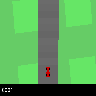

In [ ]:
# Run some steps to get an observation
env.reset()
for _ in range(50):
     observation, _,_,_ = env.step([0,0,0])
px.imshow(observation)

This is the observation space which is the space of all possible observations:

In [ ]:
env.observation_space

Box(96,96,3) essentially contains all 96x96 RBG images!

## Actions
Here is the set of possible actions (AKA the action space)

In [ ]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

Box(3,) is the set of length-3 vectors. The action `[direction, gas, break]` does the following:
* direction: -1 = left, 0 = neutral, 1 = right
* gas: 0 = foot off the gas, 1 = pedal to the metal
* break: 0 = no break, 1 = STOP IMMEDIATELY

**Exercise**: 
   * Run the below cell 3 times and explain what each action does! 
   * Are there some actions that we'd never want to do?

In [ ]:
env.action_space.sample()

array([0.96687305, 0.07583874, 0.0467314 ], dtype=float32)

In [ ]:
env.close()

## Policy

Now that we understand the environment, what should a driver in this environment do? We can model a driver as a method of selecting actions based on observations of the world. This method of selecting actions is known in RL world as a **policy**. 

We'll model **policies** in code as a function that takes in a **observation**, the environment, and a **time_step** and outputs an **action**

```
def some_policy(observation, environment, time_step) -> action:
```

Our goal for this project is to **find a good policy for for driving**

### The RL loop

The reinforment learning loop is how a policy is applied in an environment. ![image](https://cdn-media-1.freecodecamp.org/images/1*vz3AN1mBUR2cr_jEG8s7Mg.png)

We'll write the RL loop in the function called `run_racing`

**Exercise**: Complete the following function which implements the RL loop. In particular, get a move from the policy, then use `obs, reward, done, info = env.step(move)` to advance the environment using this move. Finally, check if done was true, if it was, the exit the loop using `break`.

`

In [ ]:
def run_racing(policy, max_steps=1000):
    env = gym.make("CarRacing-v0")
    env = wrap_env(env)
    obs = env.reset() # Intialize the observation
    for step in tqdm(range(min(max_steps, 1000))):
        env.render()

        ## BEGIN CODE HERE
        move = policy(obs, env, step)
        obs, reward, done, info = env.step(move)
        if done:
            break
        ## END CODE HERE

    env.close()
    show_video()

## Warmup: Simple policies

Awesome! Now let's test this loop on some simple policies.

Question: (Before running the cells) What does the following policy do?

In [ ]:
def mystery_policy_1(obs, env, ts):
    return [0,1,0]

In [ ]:
run_racing(mystery_policy_1, 200)

Track generation: 1188..1489 -> 301-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

Exercise: Create a policy that alternates between going forward, and turning left.

In [ ]:
def left_policy(obs, env, ts):
    ## BEGIN CODE HERE
    if ts % 2 == 0:
      return  [0,1,0]
    else:
      return [-1,0,0]
    ## END CODE HERE
run_racing(left_policy, 200)

Track generation: 1141..1430 -> 289-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

Exercise: Create a policy that does a random action at each step. 

Hint `env.action_space.sample()` returns a random action.

In [ ]:
def random_policy(obs, env, ts):
    ## BEGIN CODE HERE
    return env.action_space.sample()
    ## END CODE HERE
run_racing(random_policy, 200)

Track generation: 1001..1263 -> 262-tiles track


  0%|          | 0/200 [00:00<?, ?it/s]

## Using our observations

The previous policies are nice and simple but obviously are not intelligent at all! The first problem is that they don't even use their observations! Let's remind ourselves, what the observations are like. 

Track generation: 1226..1537 -> 311-tiles track



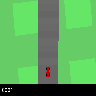

In [ ]:
# Run some steps to get an observation
env = gym.make("CarRacing-v0")
env.reset()
for _ in range(50):
     observation, _,_,_ = env.step([0,0,0])
env.close()
px.imshow(observation)

It's a nice image! But like we've seen, computers are not great at 'understanding' images. In particular this is what the computer sees.

In [ ]:
observation

array([[[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       [[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       [[102, 204, 102],
        [102, 204, 102],
        [102, 204, 102],
        ...,
        [102, 204, 102],
        [102, 204, 102],
        [102, 204, 102]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

That's kinda hard to read -.- In order to use this image to help us make a decision, we need to extract some more useful information!

Question:
* What colors are part of the road (in RGB)
* What colors are part of the grass (in RGB)
* What color is the car? (in RGB)


Exercise: Implement the following function which returns true if the image is a part of the road at a certain coordinate in the image.

Hint: You can use `img[r, c, :]` to find the color of an coordinate. Where the color is a list of 3 values (R, G, B). 

In [ ]:
def is_road(img, r, c):
    ## BEGIN CODE HERE
    for i in img[r, c, :]:
      if not(i >= 102 and i <= 107):
        return False
    return True    
    ## END CODE HERE

Run this next cell to check your work!


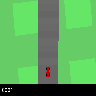

In [ ]:
def road_pixels(img):
    road = np.zeros((96,96))
    for r in range(96):
        for c in range(96):
            road[r, c] = is_road(img, r, c)
    return road

obs_road = road_pixels(observation)
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(px.imshow(observation).data[0], 1, 1)
fig.add_trace(px.imshow(obs_road).data[0], 1,2)
fig.show()

Great now let us see if we can get the car to detect a turn!

Question: How might you do this?



As a first step, let's first see whether or not there is a road in a bit in front of the car. the idea here being that we know we're at a turn if there is no longer road in front of us. Implement the front_is_road function so that the car stops right when it should turn!

* Hint: It might be useful to use to use the `is_road` function you wrote earlier!
* Hint: The car is always in the same place in the image so to get the value for a pixel in front of the car, just look at the above image! If the car stops too late, choose a pixel higher up in the image!

In [ ]:

def front_is_road(img):
    ## BEGIN CODE HERE
    for i in range(38, 56):
      if is_road(img, 50, i):
        return True
    return False
    ## END CODE HERE

def go_until_front_is_not_road(obs, env, step):
        if step < 40:
            return [0,0,0]
        if front_is_road(obs):
            return [0,1,0]
        else:
            return [0,0,1]
        
run_racing(go_until_front_is_not_road, 300)

Track generation: 1118..1404 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1206..1511 -> 305-tiles track


  0%|          | 0/300 [00:00<?, ?it/s]

Now, if we're at a turn, we need to figure out whether the turn is a right turn or a left turn!

Question: How could we determine this from the image?

* Hint: You can get the left half and the right half a grid with `grid[:,:48]` and `grid[:,48:]` respectively

In [ ]:
def is_left_turn(img):
    road = road_pixels(img)
    ## BEGIN CODE HERE
    left_sum = road[:,:48].sum()
    right_sum = road[:,48:].sum()
    return left_sum > right_sum
    ## END CODE HERE

 Run this next cell to test your code :)



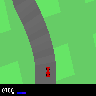

I predict that this is a left turn!



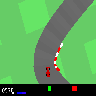

I predict that this is a right turn!


In [ ]:
imgs, _, labels = load_pkl('gathered.pkl')
px.imshow(imgs[6]).show() # This is some random image
if is_left_turn(imgs[6]):
    print("I predict that this is a left turn!")
else:
    print("I predict that this is a right turn!")
    
px.imshow(imgs[24]).show()
if is_left_turn(imgs[24]): # This is some random image
    print("I predict that this is a left turn!")
else:
    print("I predict that this is a right turn!")

**Discuss**: Is this a good way to see if there is a left turn or a right turn? 

## Free activity

Write your own driver with these tools!

We can make your driver a class in order to store some variables (allow the driver to have some memory). Below is an example to help you get started :)

Here is an idea:
* Go until front is not a road
* Stop
* Determine what kind of turn it is
* Turn until the front is a road.
* Repeat


Note: Don't worry if your driver isn't very good, we'll see much more advanced models next time!

In [ ]:
env = gym.make("CarRacing-v0")
NEUTRAL = [0,0,0]
RIGHT = [1,0,0]
LEFT = [-1, 0, 0]
ACCEL = [0,1,0]
BREAK = [0,0,1]

class Driver:
    def __init__(self):
        # TODO add stuff here that you want to access later
        # Think of these variables as the driver's memory!
        self.mode = 'accel'

    def drive(self, obs, env, ts):
        if ts < 40: # Wait for the track to load... 
            return NEUTRAL
        
        
        # TODO use self.mode to do stuff
        # OR add your own variables! Be creative :) 
        if front_is_road(obs):
            self.mode = 'accel'
            return ACCEL
        elif not front_is_road(obs):
            self.mode = 'stop'
            return BREAK
        
run_racing(Driver().drive, max_steps=200 )

## Conclusion

We took a look at the driving simulation and got some intuition on how an AI might learn how to drive! We learned some RL terminology and tried to implement some driving policies without the use of AI. 

Next time, we'll see how we can teach a car to drive by copying human actions!